<a href="https://colab.research.google.com/github/Rain1618/Hide-It/blob/main/SVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [29]:
df = pd.read_csv('/content/all_reddit_data.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,title,selftext,subreddit,name,trigger
0,0,0,Could someone send me a message?,I'm having a really hard time and could use so...,alcoholism,t3_13xwquy,addiction
1,1,1,A rock bottom story,NaN,alcoholism,t3_13xwhl7,addiction
2,2,2,Does this video infuriate anyone else or is it...,"Hi everyone. It's really nice to be here, I ju...",alcoholism,t3_13xvrek,addiction
3,3,3,How do I feel joy when I'm not drunk?,I have a fantastic life. I have a beautiful wi...,alcoholism,t3_13xvfh4,addiction
4,4,4,What to do,I just hit 5 months sober which is still mind ...,alcoholism,t3_13xuizu,addiction


In [30]:
df['trigger'].unique()

array(['addiction', 'domestic violence', 'eating disorders', 'safe',
       'sexual assault', 'suicide'], dtype=object)

In [31]:
df = df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'subreddit', 'name'], axis = 1)
df.head()

,title,selftext,trigger
0,Could someone send me a message?,I'm having a really hard time and could use so...,addiction
1,A rock bottom story,NaN,addiction
2,Does this video infuriate anyone else or is it...,"Hi everyone. It's really nice to be here, I ju...",addiction
3,How do I feel joy when I'm not drunk?,I have a fantastic life. I have a beautiful wi...,addiction
4,What to do,I just hit 5 months sober which is still mind ...,addiction


In [32]:
df['text'] = df['title'] + df['selftext']
df = df.drop(['title', 'selftext'], axis = 1)
df.head()

,trigger,text
0,addiction,Could someone send me a message?I'm having a r...
1,addiction,NaN
2,addiction,Does this video infuriate anyone else or is it...
3,addiction,How do I feel joy when I'm not drunk?I have a ...
4,addiction,What to doI just hit 5 months sober which is s...


In [33]:
len(df)

34689

In [34]:
df = df.replace(np.nan,'',regex=True)
df = df.dropna()
len(df)

31983

In [35]:
df['text'] = df['text'].str.replace(r'[^\x00-\x7F]+', '', regex=True)
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace('https:\S+|www.\S+', '', case=False)

#Word level tokenize + remove stopwords
df['token_text'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
df = df.drop('text', axis = 1)

<ipython-input-35-77f6d0911a7f>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('https:\S+|www.\S+', '', case=False)


In [25]:
df.head()

,trigger,token_text
0,addiction,"[could, someone, send, me, a, message, ?, i, '..."
2,addiction,"[does, this, video, infuriate, anyone, else, o..."
3,addiction,"[how, do, i, feel, joy, when, i, 'm, not, drun..."
4,addiction,"[what, to, doi, just, hit, 5, months, sober, w..."
5,addiction,"[i, 'm, drinking, a, whole, bottle, of, wine, ..."


In [20]:
#Modelling

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
import sklearn.metrics  
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV       


In [36]:
X = df['token_text'].astype(str)
Y = df['trigger'].astype(str)

In [37]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,Y,random_state = 42, test_size=0.2, stratify=Y)

print(X_train.shape)
print(X_test.shape)

(25586,)
(6397,)


In [38]:
classes_names = ['addiction', 'domestic violence', 'eating disorders', 'safe',
       'sexual assault', 'suicide']

encoder = LabelEncoder()
encoder.fit(classes_names)
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)
print(encoder.classes_)

['addiction' 'domestic violence' 'eating disorders' 'safe'
 'sexual assault' 'suicide']


In [39]:
#Tfidf 
Tfidf_vect = TfidfVectorizer(max_features=500) #71.15% for 500
Tfidf_vect.fit(X)
X_train = Tfidf_vect.transform(X_train)
X_test = Tfidf_vect.transform(X_test)

In [40]:
svm = svm.LinearSVC()
clf = CalibratedClassifierCV(svm) 
clf.fit(X_train,y_train_enc)
y_proba = clf.predict_proba(X_test)

In [42]:
y_proba

array([[9.21849976e-01, 3.20040717e-03, 5.74146910e-02, 1.02803192e-02,
        4.48356554e-03, 2.77104081e-03],
       [4.57410287e-02, 1.73350256e-01, 1.83901067e-02, 5.93792764e-01,
        2.55796801e-03, 1.66167877e-01],
       [2.34018411e-01, 1.96320445e-03, 7.48146580e-01, 1.50542642e-02,
        7.01352073e-04, 1.16188114e-04],
       ...,
       [2.23506254e-03, 8.80400122e-03, 3.51146066e-03, 1.56971069e-03,
        9.76217454e-01, 7.66231076e-03],
       [6.36778565e-03, 8.22616145e-02, 1.02729363e-02, 2.00263451e-04,
        8.63209322e-01, 3.76880777e-02],
       [4.83246274e-03, 3.93495853e-03, 1.22041209e-01, 4.12307569e-01,
        2.69250012e-02, 4.29958799e-01]])

###Testing different models

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# Define a list of models to test
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision tree': DecisionTreeClassifier(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(),
    'MultinminalNB': MultinomialNB(),
    'Linear SVC': svm.LinearSVC(random_state=42)
}

# Iterate over the models
for model_name, model in models.items():
    # Train the model using the TfidfVectorizer features
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

    # Print the accuracy of the current model
    print(f'{model_name}: Accuracy = {accuracy}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: Accuracy = 0.7544161325621385
Decision tree: Accuracy = 0.5773018602469908
Support Vector Machine: Accuracy = 0.7602000937939659
Random Forest: Accuracy = 0.7262779427856808
MultinminalNB: Accuracy = 0.7026731280287635


In [49]:
# svm_model = svm.LinearSVC(random_state=42)
svm.fit(X_train,y_train_enc)
preds_SVM = svm.predict(X_test)
print(svm.score(X_test,y_test_enc))
print(svm.get_params())

0.7583242144755354
{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [50]:
import joblib

# Save the model
joblib.dump(svm, 'svm_test.joblib')

['svm_test.joblib']

In [51]:
model = joblib.load('svm_test.joblib')

In [ ]:
$ tensorflowjs_converter --input_format=joblib /tmp/model.h5 /tmp/tfjs_model

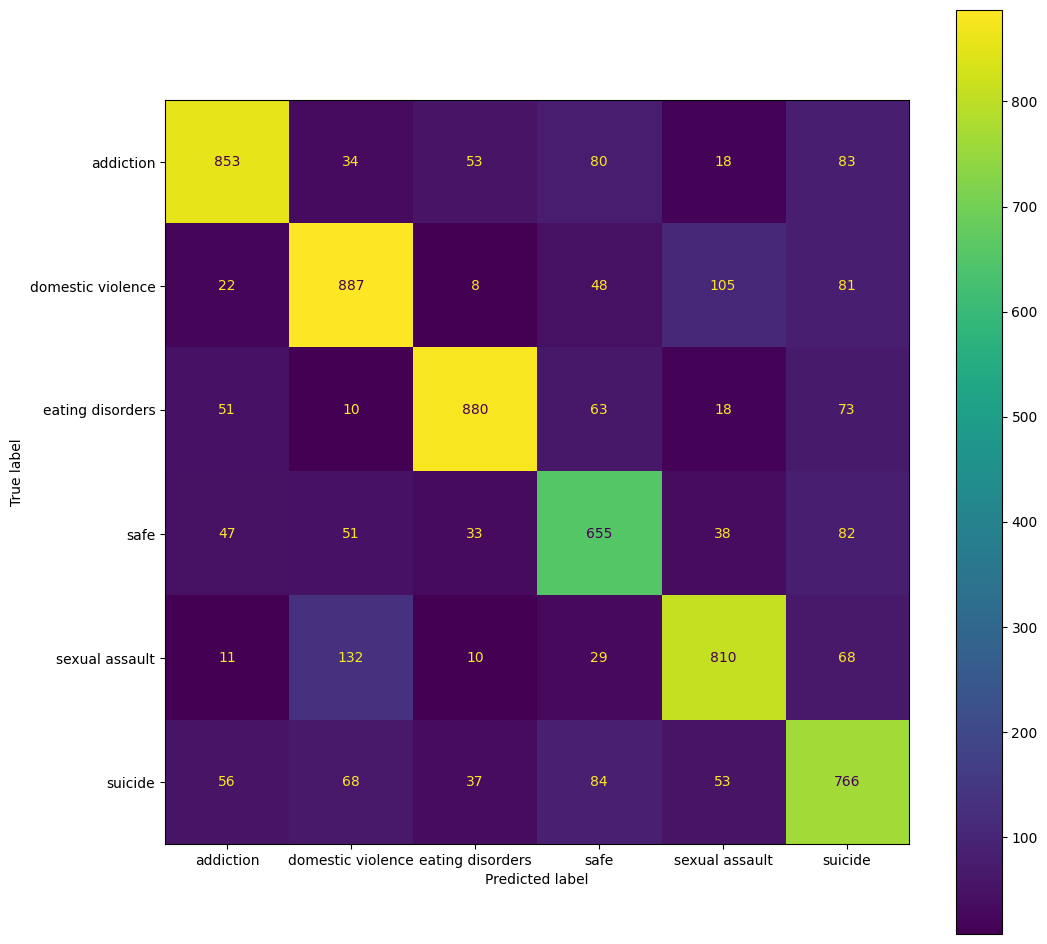

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
x=sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(y_test_enc, preds_SVM),display_labels=classes_names)
x.plot(ax=ax)
plt.show()

### Converting trained model to TensorFlow.js

In [1]:
!pip install scikit-learn
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
import numpy as np
import tensorflow as tf
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Step 1: Train and save the SKlearn model
iris = datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

sklearn_model = SVC(kernel='linear')
sklearn_model.fit(X_train, y_train)

# Step 2: Convert SKlearn model to TensorFlow model
def convert_sklearn_to_tensorflow(sklearn_model):
    # Create a TensorFlow model
    tensorflow_model = tf.keras.Sequential()

    # Iterate through the SKlearn model layers and components
    for i in range(len(sklearn_model.coef_)):
        weight = sklearn_model.coef_[i]
        bias = sklearn_model.intercept_[i]
        dense_layer = tf.keras.layers.Dense(units=1, activation='linear', use_bias=True)
        dense_layer.set_weights([np.transpose(weight), bias])
        tensorflow_model.add(dense_layer)

    # Compile the TensorFlow model
    tensorflow_model.compile(optimizer='adam', loss='mse')

    return tensorflow_model

# Convert the SKlearn model to TensorFlow model
tensorflow_model = convert_sklearn_to_tensorflow(sklearn_model)


ValueError: ignored